[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/usermarat/Flight_delays_project/blob/main/EDA_model_training.ipynb)

**Ссылка на датасет:**

https://www.kaggle.com/datasets/usdot/flight-delays

**Описание датасета:**

The U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics tracks the on-time performance of domestic flights operated by large air carriers. Summary information on the number of on-time, delayed, canceled, and diverted flights is published in DOT's monthly Air Travel Consumer Report and in this dataset of 2015 flight delays and cancellations.

In [2]:
# загрузка датасетов

! gdown 1gCWtvniGjegqFj4i3Z5W7YLakNH0Vq8Z # flights
! gdown 1yrbKRAQXp-cbRQqalJ0GZfFLSboS4Ol8 # airlines
! gdown 1eeMPTg4hFhVUdeKEcwu5sLjc7NKt7cvL # airports

Downloading...
From: https://drive.google.com/uc?id=1gCWtvniGjegqFj4i3Z5W7YLakNH0Vq8Z
To: /content/flights.csv
100% 592M/592M [00:10<00:00, 55.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yrbKRAQXp-cbRQqalJ0GZfFLSboS4Ol8
To: /content/airlines.csv
100% 359/359 [00:00<00:00, 1.72MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eeMPTg4hFhVUdeKEcwu5sLjc7NKt7cvL
To: /content/airports.csv
100% 23.9k/23.9k [00:00<00:00, 36.1MB/s]


# Установка и загрузка библиотек

In [ ]:
! pip install geopandas
! pip install catboost

     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 15.4 MB 39 kB/s 
     |████████████████████████████████| 6.3 MB 52.6 MB/s 
     |████████████████████████████████| 76.3 MB 20 kB/s 


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import geopandas as gpd
import pickle
import geopy.distance
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from catboost import CatBoostRegressor

import ipywidgets as wg
from IPython.display import display
import datetime

# Исследование данных, разбор колонок, расшифровка значений

In [ ]:
airlines = pd.read_csv('./airlines.csv')
airlines.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


In [ ]:
airlines.describe()

,IATA_CODE,AIRLINE
count,14,14
unique,14,14
top,WN,Hawaiian Airlines Inc.
freq,1,1


In [ ]:
airlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   IATA_CODE  14 non-null     object
 1   AIRLINE    14 non-null     object
dtypes: object(2)
memory usage: 352.0+ bytes


In [ ]:
airlines.isnull().sum()

IATA_CODE    0
AIRLINE      0
dtype: int64

Таблица содержит данные по 14 domestic-авиакомпаниям США, указаны их названия и коды в кодировке IATA. Все значения строковые, nan-значения отсутствуют

In [ ]:
airports = pd.read_csv('./airports.csv')
airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [ ]:
airports.describe(include='all')

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
count,322,322,322,322,322,319.000000,319.000000
unique,322,322,308,54,1,NaN,NaN
top,SFO,Meridian Regional Airport,Columbus,TX,USA,NaN,NaN
freq,1,1,2,24,322,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,38.981244,-98.378964
std,NaN,NaN,NaN,NaN,NaN,8.616736,21.523492
min,NaN,NaN,NaN,NaN,NaN,13.483450,-176.646030
25%,NaN,NaN,NaN,NaN,NaN,33.652040,-110.839385
50%,NaN,NaN,NaN,NaN,NaN,39.297610,-93.403070
75%,NaN,NaN,NaN,NaN,NaN,43.154675,-82.722995


In [ ]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  322 non-null    object 
 1   AIRPORT    322 non-null    object 
 2   CITY       322 non-null    object 
 3   STATE      322 non-null    object 
 4   COUNTRY    322 non-null    object 
 5   LATITUDE   319 non-null    float64
 6   LONGITUDE  319 non-null    float64
dtypes: float64(2), object(5)
memory usage: 17.7+ KB


In [ ]:
airports.isnull().sum()

IATA_CODE    0
AIRPORT      0
CITY         0
STATE        0
COUNTRY      0
LATITUDE     3
LONGITUDE    3
dtype: int64

In [ ]:
airports[airports.LATITUDE.isnull()]

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
96,ECP,Northwest Florida Beaches International Airport,Panama City,FL,USA,NaN,NaN
234,PBG,Plattsburgh International Airport,Plattsburgh,NY,USA,NaN,NaN
313,UST,Northeast Florida Regional Airport (St. August...,St. Augustine,FL,USA,NaN,NaN


Таблица содержит данные по 322 аэропортам США, расположенным в 308 городах/ 54 штатах - приведены IATA-коды а/п, город и штат расположения, а так же их координаты (широта/долгота). Все типы данных - строковые, за исключением координат (float). Пропущены координаты по трем аэропортам, остальные nan-значения отсутствуют.

In [ ]:
flights = pd.read_csv('./flights.csv', dtype={'ORIGIN_AIRPORT': str, 'DESTINATION_AIRPORT': str})
flights.shape

(5819079, 31)

In [ ]:
flights.sample(10).T

,5628282,3903547,1084525,2128498,203228,3676802,4007529,4174637,5439029,1322688
YEAR,2015,2015,2015,2015,2015,2015,2015,2015,2015,2015
MONTH,12,8,3,5,1,8,9,9,12,3
DAY,19,30,12,15,14,16,6,17,7,27
DAY_OF_WEEK,6,7,4,5,3,7,7,4,1,5
AIRLINE,HA,WN,WN,DL,DL,AA,AS,AA,DL,US
FLIGHT_NUMBER,140,1786,3859,1688,2128,35,528,152,637,1852
TAIL_NUMBER,N492HA,N395SW,N7731A,N311US,N136DL,N3CTAA,N596AS,N3DPAA,N996AT,N715UW
ORIGIN_AIRPORT,OGG,ATL,ROC,SAN,DTW,ORD,SEA,DCA,LAS,BOS
DESTINATION_AIRPORT,KOA,CMH,TPA,SLC,MCO,CLT,SNA,DFW,LAX,CLT
SCHEDULED_DEPARTURE,1433,2210,1255,1824,835,2149,1615,1343,1258,500


In [ ]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

In [ ]:
flights.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
YEAR,5.81908e+06,NaN,NaN,NaN,2015,0,2015,2015,2015,2015,2015
MONTH,5.81908e+06,NaN,NaN,NaN,6.52409,3.40514,1,4,7,9,12
DAY,5.81908e+06,NaN,NaN,NaN,15.7046,8.78343,1,8,16,23,31
DAY_OF_WEEK,5.81908e+06,NaN,NaN,NaN,3.92694,1.98885,1,2,4,6,7
AIRLINE,5819079,14,WN,1261855,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FLIGHT_NUMBER,5.81908e+06,NaN,NaN,NaN,2173.09,1757.06,1,730,1690,3230,9855
TAIL_NUMBER,5804358,4897,N480HA,3768,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ORIGIN_AIRPORT,5819079,628,ATL,346836,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DESTINATION_AIRPORT,5819079,629,ATL,346904,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SCHEDULED_DEPARTURE,5.81908e+06,NaN,NaN,NaN,1329.6,483.752,1,917,1325,1730,2359


Таблица содержит данные о domestic-рейсах США за 2015 г. - всего 5 819 079 полетов, по которым приведен 31 признак:
- Дата полета разбита на 4 столбца (год, месяц, число, день недели; тип данных int)
- Авиакомпания - содержит одну из 14 авикомпаний первой таблицы (str)
- Номер рейса (int)
- Хвостовой номер (str - буквенно-цифоровой код)
- Аэропорт вылета/прилета (при считывании файла выдается ошибка типа данных, подробный разбор НИЖЕ)
- Время вылета/прилета по расписанию, фактическое время вылета/прилета, время взлета/посадки самолета - задано в формате от 1 до 2400, что соответствует времени от 00:01 до 00:00 (тип данных int и float). Указывается по местному времени (время прилета не соответствует времени вылета, увеличенному на суммарное время продолжительности перелета - сходятся только минуты, часовые пояса разные)
- Время руления самолета при взлете/посадке + время самолета в воздухе = суммарное время - 3 столбца, в минутах (float)
- Расстояние между а/п в милях (проверка ниже) (int)
- Задержка вылета/прилета - задано в формате отрицательного (опережение) и положительного (задержка) значения, в минутах (float)
- Отмененные и "развернутые" рейсы - в кодировке 1/0 (int), по отмененным в отдельном столбце указан код причины - 1 из 4х (str)
- Задержки выше определенного порога разбиваются поминутно по их причинам - 5 отдельных столбцов (НИЖЕ)

In [ ]:
len(flights.ORIGIN_AIRPORT.unique()), len(airports)

(628, 322)

In [ ]:
flights.ORIGIN_AIRPORT.unique()[np.random.randint(len(flights.ORIGIN_AIRPORT.unique()), size=20)]

array(['10577', 'JAC', 'BTR', '10781', '13476', 'MTJ', '15295', '13256',
       '10581', '14027', '13296', 'MDT', 'DAB', 'JLN', '11097', '13367',
       'EGE', 'RST', 'PAH', 'PWM'], dtype=object)

In [ ]:
flights[flights.ORIGIN_AIRPORT.str.contains(r'\d')].head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
4385712,2015,10,1,4,AA,1230,N3DBAA,14747,11298,5,15.0,10.0,15.0,30.0,237.0,208.0,189.0,1660,539.0,4.0,602,543.0,-19.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4385713,2015,10,1,4,DL,1805,N696DL,14771,13487,5,16.0,11.0,14.0,30.0,213.0,192.0,171.0,1589,521.0,7.0,538,528.0,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4385714,2015,10,1,4,NK,612,N602NK,12889,13487,5,2400.0,-5.0,15.0,15.0,177.0,168.0,149.0,1299,444.0,4.0,502,448.0,-14.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4385715,2015,10,1,4,AA,260,N3GNAA,12892,13303,10,7.0,-3.0,28.0,35.0,296.0,306.0,271.0,2342,806.0,7.0,806,813.0,7.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4385716,2015,10,1,4,AA,1982,N914UY,14771,11057,10,8.0,-2.0,12.0,20.0,291.0,282.0,257.0,2296,737.0,13.0,801,750.0,-11.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
(flights[flights.ORIGIN_AIRPORT.str.contains(r'\d')].MONTH.unique(),  # месяц рейсов с иной кодировкой
len(flights[flights.ORIGIN_AIRPORT.str.contains(r'\d')]))

(array([10]), 486165)

Данные за октябрь содержат иную кодировку аэропортов - вместо 3-х буквенного IATA-кода из таблицы с аэропортами приведен 5-значный числовой код. Общее количество объектов с некорректной кодировкой - 486 тыс., что составляет более 8 % от общего количества. Для полноты и консистентности данных требуется перекодировка.

In [ ]:
# расчет расстояния с использованием модуля geopy для проверки меры измерения distance

for i in range(5):
    idx = np.random.randint(len(flights))

    print(geopy.distance.distance(*[airports.query('IATA_CODE == @air')[['LATITUDE', 'LONGITUDE']].values
                                    for air in flights.iloc[idx][['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']].values]).miles,
          flights.iloc[idx]['DISTANCE'])

# расчетное значение в милях и значение из таблицы flights

543.8236902109994 544
315.5852459549141 315
273.11086406329827 273
541.0220852159782 541
1615.8344407454922 1616


Расстояние дано в милях.

Оценка nan-значений:

In [ ]:
pd.DataFrame({'Total': flights.isnull().sum(),
              'Normal': flights.query('CANCELLED == 0 and DIVERTED == 0').isnull().sum(),
              'Divert': flights.query('DIVERTED == 1').isnull().sum(),
              'Canc': flights.query('CANCELLED == 1').isnull().sum()})

,Total,Normal,Divert,Canc
YEAR,0,0,0,0
MONTH,0,0,0,0
DAY,0,0,0,0
DAY_OF_WEEK,0,0,0,0
AIRLINE,0,0,0,0
FLIGHT_NUMBER,0,0,0,0
TAIL_NUMBER,14721,0,0,14721
ORIGIN_AIRPORT,0,0,0,0
DESTINATION_AIRPORT,0,0,0,0
SCHEDULED_DEPARTURE,0,0,0,0


In [ ]:
flights.DIVERTED.value_counts()

0    5803892
1      15187
Name: DIVERTED, dtype: int64

In [ ]:
flights.CANCELLED.value_counts()

0    5729195
1      89884
Name: CANCELLED, dtype: int64

Nan значения, в основном, все имеют смысловую нагрузку, т.е. не являются пропущенными/ошибочными значениями - проставлены по несостоявшимся (отмененным/развернутым) рейсам по таким атрибутам, как время/задержка отправления/прибытия, взлета/посадки, продолжительность пути и проч. Примечательно, что некоторые рейсы были отменены уже в процессе их исполнения (по некоторым отмененным рейсам присутствует время отправления и даже взлета). Так же по некоторым развернутым рейсам не зафиксировано время посадки/прибытия. Некоторые хвостовые номера так же не указаны по отмененным рейсам.

Причины отмены указаны только по всем отмененным рейсам, остальные признаки у состоявшихся рейсов полностью заполненны, за исключением причин задержек (об этом НИЖЕ).

In [ ]:
flights.CANCELLATION_REASON.value_counts()

B    48851
A    25262
C    15749
D       22
Name: CANCELLATION_REASON, dtype: int64

Расшифровка кодов отмены:

Cancellation Codes (A) Air Carrier; (B) Extreme Weather; (C) National Aviation System (NAS); and (D) Security.

https://www.iata.org/en/services/codes/

Рейсы с задержками

In [ ]:
pd.DataFrame({'Dep_del': flights.query('DEPARTURE_DELAY > 0 and ARRIVAL_DELAY <= 0').notnull().sum()[-5:],
              'Arr_del': flights.query('ARRIVAL_DELAY > 0').isnull().sum()[-5:]})

,Dep_del,Arr_del
AIR_SYSTEM_DELAY,0,1023457
SECURITY_DELAY,0,1023457
AIRLINE_DELAY,0,1023457
LATE_AIRCRAFT_DELAY,0,1023457
WEATHER_DELAY,0,1023457


In [ ]:
(max(flights[flights.AIR_SYSTEM_DELAY.isnull()].ARRIVAL_DELAY),
min(flights[flights.AIR_SYSTEM_DELAY.notnull()].ARRIVAL_DELAY))

(14.0, 15.0)

In [ ]:
len(flights.query('ARRIVAL_DELAY > 0')) - len(flights.query('ARRIVAL_DELAY > 14'))

1023457

In [ ]:
flights.query('ARRIVAL_DELAY > 14').head(10)[['ARRIVAL_DELAY', 'AIR_SYSTEM_DELAY',
                                            'SECURITY_DELAY', 'AIRLINE_DELAY',
                                            'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']]

,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
27,25.0,25.0,0.0,0.0,0.0,0.0
30,43.0,43.0,0.0,0.0,0.0,0.0
35,15.0,0.0,0.0,15.0,0.0,0.0
50,20.0,20.0,0.0,0.0,0.0,0.0
52,85.0,0.0,0.0,85.0,0.0,0.0
55,89.0,17.0,0.0,72.0,0.0,0.0
70,102.0,0.0,0.0,0.0,0.0,102.0
73,60.0,0.0,0.0,60.0,0.0,0.0
74,54.0,0.0,0.0,54.0,0.0,0.0
86,66.0,13.0,0.0,53.0,0.0,0.0


Столбцы с задержками заполнены только у рейсов с задержками прибытия от 15ти минут. Причины задержек отправки, при условии отсутствия задержки прибытия, не заполняются.

Общее время задержки разбивается поминутно по соотв. столбцам причин

In [ ]:
_ = flights.query('ARRIVAL_DELAY >= 15')[['AIR_SYSTEM_DELAY', 'SECURITY_DELAY',
                                      'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']] > 0
_.sum()

AIR_SYSTEM_DELAY       564826
SECURITY_DELAY           3484
AIRLINE_DELAY          570022
LATE_AIRCRAFT_DELAY    556953
WEATHER_DELAY           64716
dtype: int64

In [ ]:
flights[['AIR_SYSTEM_DELAY', 'SECURITY_DELAY',
         'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']].sum()

AIR_SYSTEM_DELAY       14335762.0
SECURITY_DELAY            80985.0
AIRLINE_DELAY          20172956.0
LATE_AIRCRAFT_DELAY    24961931.0
WEATHER_DELAY           3100233.0
dtype: float64

# Корректировка проблемных данных, их преобразование и формирование итоговой таблицы

В первую очередь, требуется перекодировать аэропорты. В общем доступе, в т.ч. на официальном сайте https://www.transtats.bts.gov необходимые данные, к сожалению, не нашел, поэтому пришлось придумывать, как самостоятельно расшифровать коды

Идея расшифровки следующая - специфика авиаперелетов в их постоянности, регулярности и пунктуальности, т.е. как правило, конкретные рейсы каждой авиакомпании повторяются на периодичной основе и совершаются в одно и то же время (например, каждый день в 9.00 такая-то авикомпания летит из такого-то аэропорта в другой; это может измениться только в связи с опозданием/опережением вылета, что является исключением).

Соответственно, предлагается взять предыдущий месяц, объединить признаки: время вылета по расписанию, авикомпания и расстояние между аэропортами (производный признак от расположения аэропортов, косвенно показывающий на то, между какими аэропортами осуществляется перелет) и смерджить с требуемым месяцем по объединению данных признаков. С учетом массовости полетов, указанной специфики авиатранспорта и использования для объединения данных за предыдущий месяц (меньшая вероятность изменения в регулярных рейсах), большинство кодов должно быть корректно расшифровано.

In [ ]:
october = flights.query('MONTH == 10')[['MONTH', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
                                        'DISTANCE', 'AIRLINE', 'SCHEDULED_DEPARTURE']]

september = flights.query('MONTH == 9')[['MONTH', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
                                        'DISTANCE', 'AIRLINE', 'SCHEDULED_DEPARTURE']]

october['joined'] = october[['DISTANCE', 'AIRLINE',
                             'SCHEDULED_DEPARTURE']].apply(lambda x: ' '.join(map(str, x)), axis=1)

september['joined'] = september[['DISTANCE', 'AIRLINE',
                                 'SCHEDULED_DEPARTURE']].apply(lambda x: ' '.join(map(str, x)), axis=1)

sep_oct = october.merge(september, how='inner', left_on='joined', right_on='joined')

air_codes = {}

# по объединенной таблице забираются требуемые коды, полученные подсчетом наиболее часто встречающихся значений

for code in sep_oct.ORIGIN_AIRPORT_x.unique():
    let = sep_oct.query('ORIGIN_AIRPORT_x == @code')['ORIGIN_AIRPORT_y'].value_counts().index[0]
    air_codes.update({code: let})

len(air_codes), len(october.ORIGIN_AIRPORT.unique())

(298, 306)

298 из 306 кодов расшифровано, сохраним результат

In [ ]:
with open('/gdrive/My Drive/air_codes.pickle', 'wb') as f:
    pickle.dump(air_codes, f)

# проверка результата
sep_oct.sample(10).replace({'ORIGIN_AIRPORT_x': air_codes,
                            'DESTINATION_AIRPORT_x': air_codes})[['ORIGIN_AIRPORT_x', 'DESTINATION_AIRPORT_x', 'ORIGIN_AIRPORT_y', 'DESTINATION_AIRPORT_y']]

,ORIGIN_AIRPORT_x,DESTINATION_AIRPORT_x,ORIGIN_AIRPORT_y,DESTINATION_AIRPORT_y
4228122,CLT,DTW,CLT,DTW
2684520,BWI,OAK,BWI,OAK
4817232,SAN,SMF,SAN,SMF
2237802,DCA,LGA,DCA,LGA
4408297,SAN,MSP,SAN,MSP
927989,DFW,ORD,DFW,ORD
2747689,MDW,BWI,MDW,BWI
4693058,LAS,MKE,LAS,MKE
2753462,ORD,PHX,ORD,PHX
366341,MFR,SFO,MFR,SFO


In [ ]:
# замена значений кодировки аэропортов в датасете
flights.replace({'ORIGIN_AIRPORT': air_codes,
                 'DESTINATION_AIRPORT': air_codes}, inplace=True)

len(flights[flights.ORIGIN_AIRPORT.str.contains(r'\d')]) + len(flights[flights.DESTINATION_AIRPORT.str.contains(r'\d')])

1249

"Нерасшифрованными" осталось всего 1249 рейсов, что составляет порядка 0,01 % всех объектов - можно пренебречь, удаляем

In [ ]:
idx = list(flights[flights.ORIGIN_AIRPORT.str.contains(r'\d')].index) + list(flights[flights.DESTINATION_AIRPORT.str.contains(r'\d')].index)
flights.drop(index=idx, inplace=True)

flights.to_csv('/gdrive/My Drive/flights_new.csv')

Заполнение пропущенных координат

In [ ]:
ecp = (30.3582408,-85.7956022)
pbg = (44.65083, -73.46806)
ust = (29.9586, -81.3389)

idx = airports[airports.LATITUDE.isnull()].index

airports.LATITUDE.fillna(pd.Series(list(zip(ecp, pbg, ust))[0], index=idx), inplace=True)
airports.LONGITUDE.fillna(pd.Series(list(zip(ecp, pbg, ust))[1], index=idx), inplace=True)

airports.to_csv('/gdrive/My Drive/airports_new.csv')

Конвертация и переформатирование временных признаков; в связи с различиями по некоторым рейсам дней вылета/прилета (перелет на рубеже полуночи) соответствующие признаки не будут переводиться в формат Timestamp (иначе будет некорретное отражение даты), будет сохранено местное время вылета/прилета - переведено в более понятный формат datetime.time

In [ ]:
time_cols = ['SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'WHEELS_OFF', 'WHEELS_ON', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME']

for col in tqdm(time_cols):
    flights['HOUR'] = np.where(flights[col].values <= 59, 0, flights[col].values // 100)
    flights['MINUTE'] = np.where(flights[col].values <= 59, flights[col].values, flights[col].values % 100)
    flights[col] = pd.to_datetime(flights[['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE']])
    flights[col] = flights[col].apply(lambda x: x.time() if x is not pd.NaT else x) # необходимо исключать из обработки nan значения

flights['DATE'] = pd.to_datetime(flights[['YEAR', 'MONTH', 'DAY']])
flights.drop(['HOUR', 'MINUTE'], axis=1, inplace=True)

  0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in floor_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in remainder
  """


Сэмпл итоговой таблицы:

In [ ]:
flights.sample(10).T

,4962254,3165881,1586161,2409362,5695924,460436,1218685,4821572,4235675,1001520
YEAR,2015,2015,2015,2015,2015,2015,2015,2015,2015,2015
MONTH,11,7,4,6,12,1,3,10,9,3
DAY,6,17,12,2,23,31,20,28,21,7
DAY_OF_WEEK,5,5,7,2,3,6,5,3,1,6
AIRLINE,MQ,DL,WN,DL,AA,OO,EV,UA,OO,EV
FLIGHT_NUMBER,3372,1554,475,1589,1833,5556,5354,1948,6395,4120
TAIL_NUMBER,N530MQ,N582NW,N601WN,N666DN,N959UW,N791SK,N538CA,N87513,N144SY,N12142
ORIGIN_AIRPORT,LGA,LAX,MCI,FLL,PHL,LAX,MSP,TPA,BNA,LGA
DESTINATION_AIRPORT,XNA,ATL,BOS,ATL,ATL,AUS,MSN,IAH,ORD,CLE
SCHEDULED_DEPARTURE,14:26:00,14:50:00,11:30:00,11:45:00,18:20:00,08:30:00,15:30:00,15:09:00,13:22:00,11:01:00


# EDA и визуализация

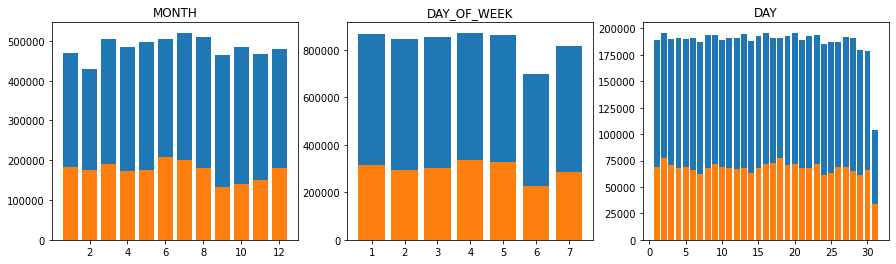

In [ ]:
plt.figure(figsize=(15, 4))
for ax, col, unit in zip(range(1, 4), ['MONTH', 'DAY_OF_WEEK', 'DAY'], [13, 8, 32]):
    a = plt.subplot(1,3,ax)
    plt.bar(range(1, unit), flights[col].value_counts().sort_index())
    plt.bar(range(1, unit), flights.query('ARRIVAL_DELAY > 0')[col].value_counts().sort_index())
    a.set_title('{}'.format(col))

Количество рейсов в разбивке по месяцам, дням недели и числам месяца, в т.ч. с задержкой прибытия от 1ой минуты. Наибольшее количество рейсов приходится на июнь-август, в феврале просадка, так же меньшее количество рейсов совершалось по субботам и воскресеньям. По числам месяца распределением количества равномерное, не считая последние, что связано с некоторыми месяцами с меньшими количествами календарных дней. Наименьшее количество рейсов с задержкой приходится на сентябрь-ноябрь, по дням недели - в субботу и воскресенье, но в эти дни недели и так совершается меньше всего рейсов.

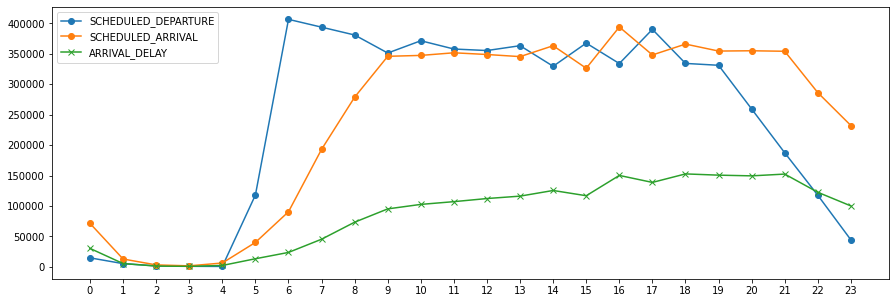

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(flights['SCHEDULED_DEPARTURE'].apply(lambda x: x.hour).value_counts().sort_index(), '-o',
         flights['SCHEDULED_ARRIVAL'].apply(lambda x: x.hour).value_counts().sort_index(), '-o',
         flights.query('ARRIVAL_DELAY > 0')['SCHEDULED_ARRIVAL'].apply(lambda x: x.hour).value_counts().sort_index(), '-x')

plt.legend(['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'ARRIVAL_DELAY'])
plt.xticks(range(24));

Подсчет количества рейсов по времени суток - минимальное количество рейсов приходится на ночные/утренние часы, далее в течение дня количество рейсов по расписанию примерно одинаковое. С ростом количества рейсов в соответствующие часы суток увеличиваются и задержанные рейсы.

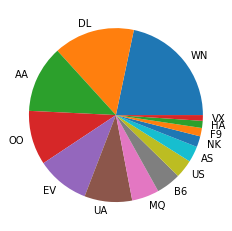

In [ ]:
plt.figure()
plt.pie(flights['AIRLINE'].value_counts(), labels=flights['AIRLINE'].value_counts().index);

Доли авиакомпаний в перелетах за рассматриваемый период, в лидерах - WN, DL, AA.

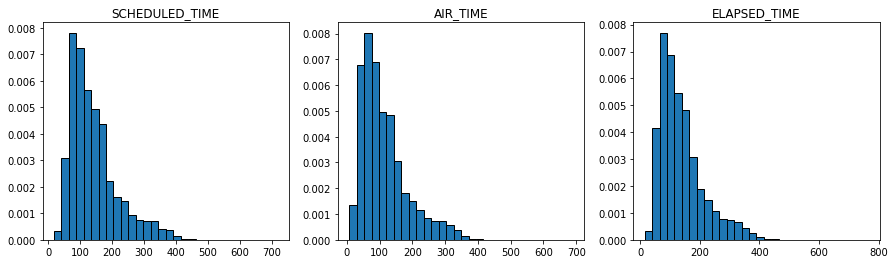

In [ ]:
plt.figure(figsize=(15, 4))
for ax, col in zip(range(1,4), ['SCHEDULED_TIME', 'AIR_TIME', 'ELAPSED_TIME']):
    a = plt.subplot(1,3,ax)
    plt.hist(flights[col].values, edgecolor='black', bins=30, density=True)
    a.set_title('{}'.format(col));

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


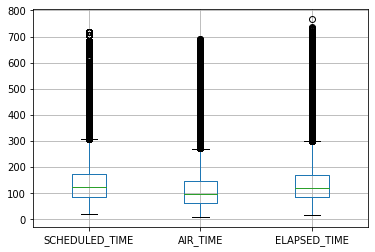

In [ ]:
flights[['SCHEDULED_TIME', 'AIR_TIME', 'ELAPSED_TIME']].boxplot();

Распределение количества рейсов по времени перелета, общего времени и планового времени рейсов. В связи с большим интервалом третьего квартиля отмечается большое количество выбросов - 25 % всех рейсов разбросано по интервалу времени перелета от 144-177 минут (75ые перцентили) до 690-766 минут (максимальные показатели), в то время как основное количество рейсов сосредоточено в пределах +/- 100 минут. В результате гистограммы имеют длинные "хвосты" с правой стороны, невидимые из-за малого количества наблюдений, боксплот так же указывает на большое количество выбросов - рейсы с продолжительностью от 300 минут.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


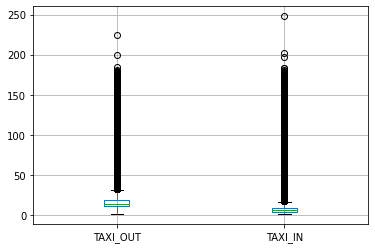

In [ ]:
flights[['TAXI_OUT', 'TAXI_IN']].boxplot();

Аналогичная картина по параметрам времени руления - третий квартиль начинается с 9-19 минут и завершается максимальными значениями 225-248 минут (порядка 4х часов руления - как видно из боксплота это экстремальные пара значений, крайние значения остальных заканчиваются на отметке порядка 180-190 минут, что тоже достаточно много - ок. 3 часов), сама медиана проходит на уровне 6-14 минут. В результате боксплот так же указывает на большое количество выбросов.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


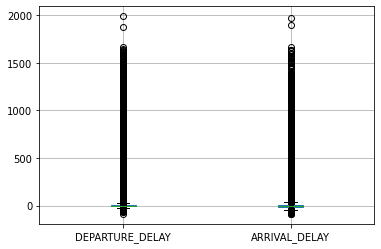

In [ ]:
flights[['DEPARTURE_DELAY', 'ARRIVAL_DELAY']].boxplot();

Еще больше выбросов по показателям задержек вылета и прилета, при чем они есть, как сверху, так и снизу: по основным количествам рейсов данные показатели составляют от опережения в 5-13 минут до опоздания на 7-8 минут (25ый и 75ый перцентили), тогда как показателия начинаются с минимума опережения на 82-87 минуты и заканчиваются максимальными опозданиями у нескольких рейсов в 1971-1988 минут, т.е. почти до полутора суток.

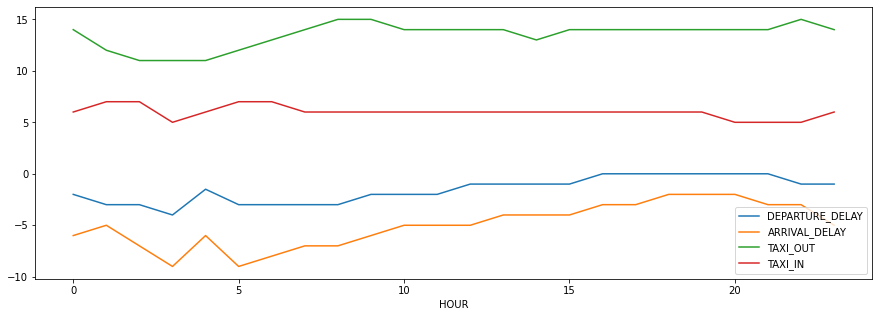

In [ ]:
flights.groupby('HOUR')[['DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'TAXI_OUT', 'TAXI_IN']].median().plot(figsize=(15,5));

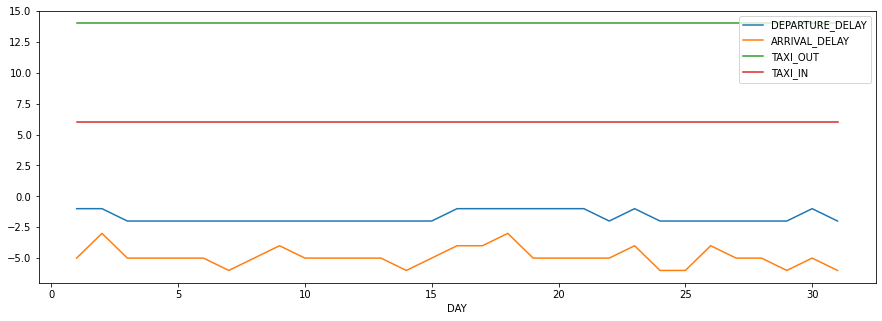

In [ ]:
flights.groupby('DAY')[['DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'TAXI_OUT', 'TAXI_IN']].median().plot(figsize=(15,5));

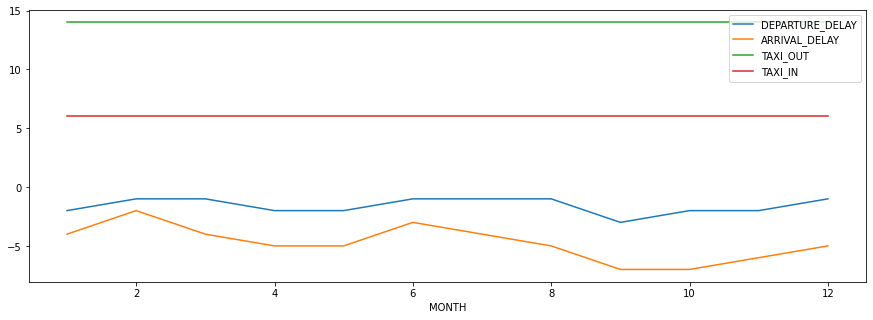

In [ ]:
flights.groupby('MONTH')[['DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'TAXI_OUT', 'TAXI_IN']].median().plot(figsize=(15,5));

Медианные значения задержек отправления и прибытия, а также руления при взлете и посадке в группировке по дням, часам и месяцам рейса. Заметно, что в течение суток задержки постепенно возрастают и становятся максимальными к полуночи. Так же виден всплеск в 4 утра. По дням существенной зависимости не наблюдается, по месяцам видно, что максимальные задержки приходятся на начало года, минимальные - на сентябрь.

Интересны медианные значения показателей руления - в группировке по дням и месяцам они принимают одинаковые значения, что может указывать на постоянный характер регулярных авиарейсов в датасете с одной стороны, а с другой - для каждого конкретного авиарейса/авиакомпании/аэропорта это своеобразная константная величина.

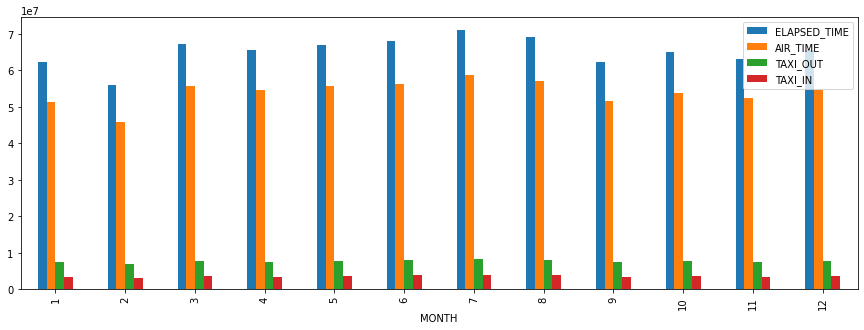

In [ ]:
flights.groupby('MONTH')[['ELAPSED_TIME', 'AIR_TIME', 'TAXI_OUT', "TAXI_IN"]].sum().plot(kind='bar', figsize=(15,5));

Разложение суммы общего времени рейса на элементные составляющие - время в воздухе, руления при взлете и посадке.

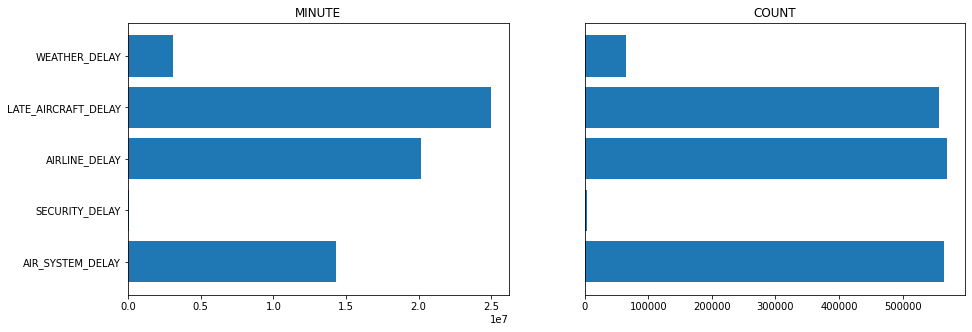

In [ ]:
plt.figure(figsize=(15, 5))
ax = plt.subplot(1,2,1)
plt.barh(['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
         flights.query('ARRIVAL_DELAY < 1500')[['AIR_SYSTEM_DELAY', 'SECURITY_DELAY',
                                                'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                                                'WEATHER_DELAY']].sum().values)
ax.set_title('MINUTE')

ax = plt.subplot(1,2,2)
_ = flights.query('ARRIVAL_DELAY < 1500')[['AIR_SYSTEM_DELAY', 'SECURITY_DELAY',
                                           'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                                           'WEATHER_DELAY']] > 0
plt.barh(_.sum().index, _.sum())
ax.set_title('COUNT')
plt.yticks([]);

Причины задержки по суммарному времени и по количествам возникновения. Наиболее частые причины задержки - задержка самолета, авиакомпании, воздушной системы, при этом последняя причина возникала так же часто, как и остальные, однако по суммарному времени она на третьем месте, т.е. такие задержки случаются достаточно часто, но все они недолгие сравнительно с остальными причинами. Так же интересно наибольшее количество задержек по вине авиакомпаний, но значительно меньшее их суммарное время относительно задержек по причине задержки самолета. По погодным причинам задержек относительно немного как по их количеству, так и по суммарному времени, по причинам безопасности - незначительно количество.

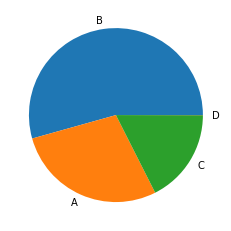

In [ ]:
plt.pie(flights.CANCELLATION_REASON.value_counts(), labels=flights.CANCELLATION_REASON.value_counts().index);

Наиболее частая причина отмены рейсов - погодные причины, что отчасти объясняет низкий показатель количества и суммарного времени задержек рейсов по погодным причинам - они просто были отменены. Далее наиболее частые причины отмены - по вине авиакомпании и регулирование воздушной системы. По причине безопасности было отменено незначительное количество рейсов.

<Figure size 432x288 with 0 Axes>

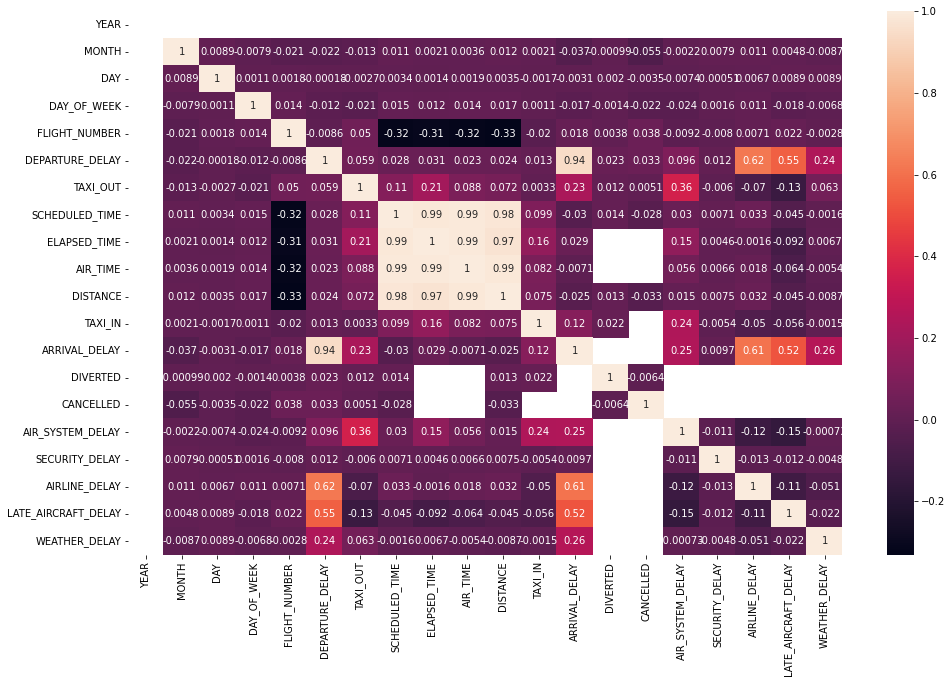

In [ ]:
corr = flights.corr()
plt.tight_layout()
plt.figure(figsize=(16,10))
sns.heatmap(corr, annot=True)

Тепловая карта корреляций. По понятным причинам связаны показатели общего времени перелета, времени самолета в воздухе, расстояния между аэропортами, а также связаны задержки прилета/вылета, причины задержек. Интересна небольшая обратная зависимость номера рейса и времени перелета, дистанции, логике не поддается - скорее всего ложная, хотя может есть какая-то специальная система нумерации, в зависимости от дальности рейсов. Из интересного еще небольшая прямая связь времени руления и опозданий по причине регулирования воздушной системы - время руления увеличивается ввиду действий регулятора, ну или чаще всего регулируются аэропорты, обладающие определенной спецификой в части продолжительности руления.

# Создание network и ее визуализация

In [ ]:
# Загрузка карты мира
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Создание network-сети уникальных направленных связей между аэропортами
# (направленные ребра - рейсы между а/п)
G = nx.from_pandas_edgelist(flights, 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
                            create_using=nx.DiGraph)

# нодам задаются атрибуты координат
airports.set_index('IATA_CODE', inplace=True)
loc = {idx: (airports['LONGITUDE'][idx], airports['LATITUDE'][idx]) for idx in airports.index}
nx.set_node_attributes(G, values=loc, name='location')

# ребрам задаются атрибуты количества совершенных рейсов между соотв. а/п-нодами
flight_counts = flights.groupby(['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'])['FLIGHT_NUMBER'].count().to_dict()
nx.set_edge_attributes(G, values=flight_counts, name='counts')

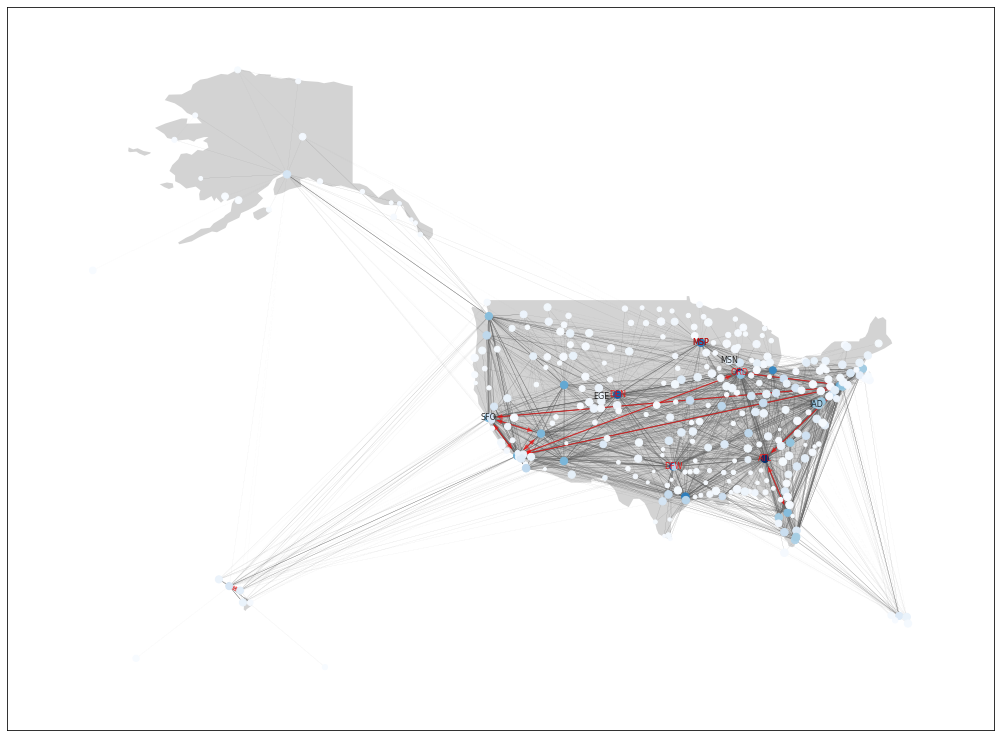

In [ ]:
fig, ax = plt.subplots(figsize=(14,12))
# Схема карты США
countries.query('name == "United States of America"').plot(color="lightgrey", ax=ax)

# Параметры для отрисовки сети

# Расположение нодов
pos = nx.get_node_attributes(G, 'location')

# Цвет и размер нодов, толщина ребер
node_color = [G.degree(v) for v in G]
cls_centr = nx.closeness_centrality(G, distance='counts')
node_size = [20000*cls_centr[v] for v in G]
edge_width = [0.00004*G[u][v]['counts'] for u,v in G.edges()]

# Отрисовка сети
nx.draw_networkx(G, pos, node_size=node_size, arrows=False,
                 node_color=node_color, alpha=1, with_labels=False,
                 width=edge_width, edge_color='.4', cmap=plt.cm.Blues, ax=ax)

# Подписи к наиболее важным нодам
btw_centr = nx.betweenness_centrality(G, weight='counts')
btw_centr_sort = sorted(btw_centr.items(), reverse=True, key=lambda x: x[1])
nx.draw_networkx_labels(G, pos, labels={v[0]: v[0] for v in btw_centr_sort[:5]}, font_size=8, alpha=0.8)

degr_sort = sorted([(v, G.degree(v)) for v in G], key=lambda x: x[1], reverse=True)
nx.draw_networkx_labels(G, pos, labels={v[0]: v[0] for v in degr_sort[:5]}, font_size=8, font_color='r', alpha=0.8)

# Выделение наиболее важных ребер
edge_sort = sorted([v for v in G.edges(data=True)], key=lambda x: x[2]['counts'], reverse=True)[:20]
nx.draw_networkx_edges(G, pos, edgelist=edge_sort, edge_color='r', alpha=0.4, width=1)

plt.tight_layout();

Схема карты США с наложением network-сети, состоящей из нодов-аэропортов, расположенных в соответствии с их координатами, и ребер - все уникальные рейсы-маршруты между соответствующими а/п из датасета (сам граф имеет направленность, для разгрузки изображения стрелки отключены). В качестве атрибутов-весов к ребрам графа добавлены количества совершенных рейсов по соответствующим маршрутам, координаты а/п сохранены в атрибутах соотв. нодов.

Цвет точек на схеме отражает количество "соседних" нодов, с которым соотв. нод связан - чем темнее цвет, тем больше у него "соседей"-а/п, с которыми их связывают прямые рейсы (показатель degree).

Размер точек отражает показатель closeness-centrality - "близость" рассматриваемого нода ко всем остальным. Рассчитывается как отношение суммарного количества нодов в сети за минусом одного на сумму кратчайших путей от рассматриваемого нода до каждого из остальных; пути (наименьшее количество прямых рейсов по цепочке из начального а/п до конечного) рассчитываются с учетом параметров-весов соответствующих ребер на данном пути. Чем больше точка, тем выше данный показатель и тем "быстрее" (за меньшее количество прямых рейсов) можно добраться из данного нода-а/п до всех остальных.

Толщина/жирность ребер отражает параметр его веса - чем толще линия, тем большее количество рейсов было совершено по данному маршруту за рассматриваемый период.

Дополнительно на схеме отмечены наиболее важные ноды-а/п и ребра-рейсы:
- черным шрифтом указаны а/п с наивысшими значениями показателя betweenness_centrality - "степень соединения" всех остальных нодов через рассматриваемый. Рассчитывается как сумма отношений количества всех коротких путей между всеми нодами в сети к количеству данных путей, проходящих через рассматриваемый нод. Чем он выше, тем больше кратчайших путей между всеми нодами сети проходит через рассматриваемый нод, т.е. данные ноды можно условно назвать распределительными хабами-а/п, через которые чаще всего проходят "пересадки" непрямых рейсов до всех остальных нодов-а/п. Следует отметить, что у многих а/п данный параметр принимает нулевое значение, что объясняется большим количеством нодов-а/п на периферии - по границе страны и на отдельных территориях (Аляска, Гавайские и Виргинские острова), в основном данные ноды не имеют большого количества связей, только 1-2 рейса, соединяющих их с ближайшими а/п.
- красным шрифтом указаны а/п с наибольшим количеством связей с а/п-"соседями", тоже своего рода хабы, от которых исходит и в которые входит огромное количество прямых рейсов из большого количества иных а/п.
- красным цветом выделены ребра-маршруты с наибольшим количеством совершенных рейсов по данным маршрутам, данный атрибут используется в качестве веса во всех вышеуказанных расчетах.

Как видно, большинство наиболее важных а/п-хабов расположено в центральных районах, за исключением SFO - скорее всего это объясняется тем, что данный а/п является одним из 3х основных, соединяющих всю страну с Гавайскими островами, при этом на данных островах присутствует маршрут с очень высоким весом, входящим в топ-10 по количеству совершенных рейсов по данному маршруту, за счет этого важность SFO выросла. Кроме того, в свою очередь SFO (Санк-Франциско) так же имеет маршруты-связи с высокими весами.

Наиболее важные маршруты соединяют JFK (Нью-Йорк) с противоположным берегом (SFO, LAX - Лос-Анджелес) и с некоторыми крупными хабами, что тоже логично. Как видно, все топ-10 маршрутов имеют двустороннее направление (для наглядности сохранены стрелки), т.е. количество рейсов "туда", как правило, соответствует количеству рейсов "обратно", что в принципе соотносится с логикой датасета, содержащего информацию по регулярным domestic-рейсам.

Расшифровки кодов а/п к подписям ниже.

In [ ]:
top_red = airports.loc[[aip[0] for aip in degr_sort[:5]]]
top_red.insert(len(airports.columns),column='DEGR', value=[aip[1] for aip in degr_sort[:5]])
top_red

,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,DEGR
IATA_CODE,,,,,,,
ATL,Hartsfield-Jackson Atlanta International Airport,Atlanta,GA,USA,33.64044,-84.42694,338
ORD,Chicago O'Hare International Airport,Chicago,IL,USA,41.97960,-87.90446,324
DFW,Dallas/Fort Worth International Airport,Dallas-Fort Worth,TX,USA,32.89595,-97.03720,297
DEN,Denver International Airport,Denver,CO,USA,39.85841,-104.66700,279
MSP,Minneapolis-Saint Paul International Airport,Minneapolis,MN,USA,44.88055,-93.21692,242


In [ ]:
top_black = airports.loc[[aip[0] for aip in btw_centr_sort[:5]]]
top_black.insert(len(airports.columns),column='BTW', value=[aip[1] for aip in btw_centr_sort[:5]])
top_black

,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,BTW
IATA_CODE,,,,,,,
IAD,Washington Dulles International Airport,Chantilly,VA,USA,38.94453,-77.45581,0.416896
MSN,Dane County Regional Airport,Madison,WI,USA,43.13986,-89.33751,0.254261
EGE,Eagle County Regional Airport,Eagle,CO,USA,39.64257,-106.91770,0.249286
SFO,San Francisco International Airport,San Francisco,CA,USA,37.61900,-122.37484,0.237005
MSP,Minneapolis-Saint Paul International Airport,Minneapolis,MN,USA,44.88055,-93.21692,0.218158


In [ ]:
edge_sort

[('SFO', 'LAX', {'counts': 15116}),
 ('LAX', 'SFO', {'counts': 14799}),
 ('JFK', 'LAX', {'counts': 13113}),
 ('LAX', 'JFK', {'counts': 13106}),
 ('LAS', 'LAX', {'counts': 10657}),
 ('LGA', 'ORD', {'counts': 10560}),
 ('LAX', 'LAS', {'counts': 10539}),
 ('ORD', 'LGA', {'counts': 10492}),
 ('JFK', 'SFO', {'counts': 9280}),
 ('SFO', 'JFK', {'counts': 9279}),
 ('OGG', 'HNL', {'counts': 9086}),
 ('LAX', 'ORD', {'counts': 9070}),
 ('HNL', 'OGG', {'counts': 9055}),
 ('ATL', 'MCO', {'counts': 8964}),
 ('MCO', 'ATL', {'counts': 8962}),
 ('ATL', 'LGA', {'counts': 8909}),
 ('LGA', 'ATL', {'counts': 8887}),
 ('SFO', 'LAS', {'counts': 8798}),
 ('ORD', 'LAX', {'counts': 8720}),
 ('LAS', 'SFO', {'counts': 8664})]

In [ ]:
airports.loc[{aip[0] for aip in edge_sort}]

,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
IATA_CODE,,,,,,
SFO,San Francisco International Airport,San Francisco,CA,USA,37.61900,-122.37484
JFK,John F. Kennedy International Airport (New Yor...,New York,NY,USA,40.63975,-73.77893
MCO,Orlando International Airport,Orlando,FL,USA,28.42889,-81.31603
LGA,LaGuardia Airport (Marine Air Terminal),New York,NY,USA,40.77724,-73.87261
LAS,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233
HNL,Honolulu International Airport,Honolulu,HI,USA,21.31869,-157.92241
ATL,Hartsfield-Jackson Atlanta International Airport,Atlanta,GA,USA,33.64044,-84.42694
LAX,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807
OGG,Kahului Airport,Kahului,HI,USA,20.89865,-156.43046


# Задание № 1 - а/п с минимальной задержкой вылета

In [ ]:
flights = flights.merge(airports, left_on='ORIGIN_AIRPORT', right_index=True)
normal_flights = flights.query('DIVERTED == 0 and CANCELLED == 0')

In [ ]:
dep_del_min = normal_flights.groupby(['ORIGIN_AIRPORT', 'LATITUDE', 'LONGITUDE',
                                       'AIRPORT',	'CITY',	'STATE'],
                                      as_index=False)['DEPARTURE_DELAY'].median().sort_values('DEPARTURE_DELAY')

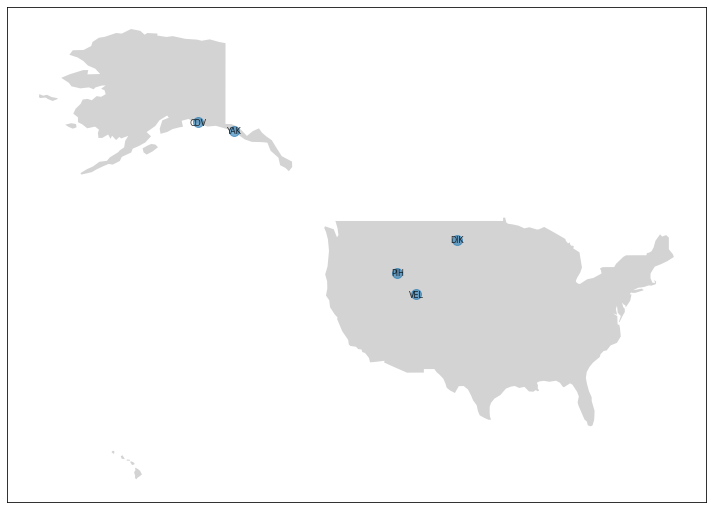

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
countries.query('name == "United States of America"').plot(color="lightgrey", ax=ax)

pos_dep = dep_del_min.ORIGIN_AIRPORT.values[:5]
nx.draw_networkx_nodes(G, pos, pos_dep, node_size=100, alpha=0.6, ax=ax)
nx.draw_networkx_labels(G, pos, labels={v: v for v in pos_dep}, alpha=0.8, font_size=8)

plt.tight_layout();

In [ ]:
dep_del_min.iloc[:5]

,ORIGIN_AIRPORT,LATITUDE,LONGITUDE,AIRPORT,CITY,STATE,DEPARTURE_DELAY
320,YAK,59.50336,-139.66023,Yakutat Airport,Yakutat,AK,-12.0
56,CDV,60.49183,-145.47765,Merle K. (Mudhole) Smith Airport,Cordova,AK,-10.0
314,VEL,40.44090,-109.50992,Valdez Airport,Vernal,UT,-9.0
88,DIK,46.79739,-102.80195,Dickinson Theodore Roosevelt Regional Airport,Dickinson,ND,-8.0
242,PIH,42.91131,-112.59586,Pocatello Regional Airport,Pocatello,ID,-8.0


# Задание № 2 - самая пунктуальная авиакомпания на прилет в Los Angeles IA

In [ ]:
lax = normal_flights.query('DESTINATION_AIRPORT == "LAX"').copy()
lax['DELAY_LEVEL'] = pd.cut(lax['ARRIVAL_DELAY'], [-5000, -60, -5, 5, 60, 5000],
                            labels=['super_early', 'early', 'ontime', 'late', 'super_late'])

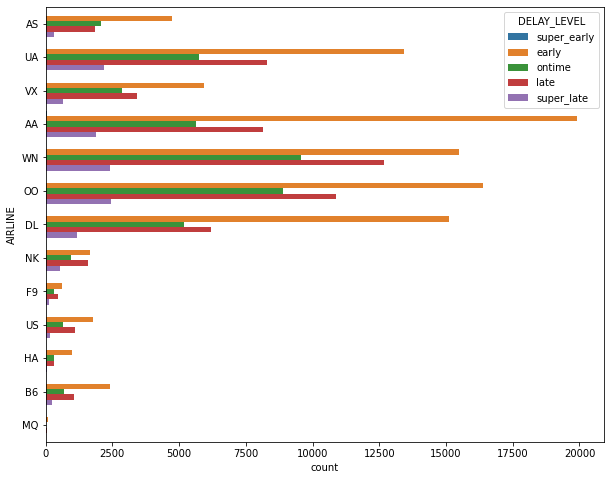

In [ ]:
plt.figure(figsize=(10,8))

sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=lax)

In [ ]:
df = lax.groupby(['AIRLINE', 'DELAY_LEVEL'], as_index=False).FLIGHT_NUMBER.count()
on_time_fract = df.query('DELAY_LEVEL == "ontime"').set_index('AIRLINE')['FLIGHT_NUMBER'] / df.groupby('AIRLINE').FLIGHT_NUMBER.sum()
pd.merge(on_time_fract.sort_values(ascending=False), airlines, left_index=True, right_on='IATA_CODE')

,FLIGHT_NUMBER,IATA_CODE,AIRLINE
8,0.238820,WN,Southwest Airlines Co.
6,0.231018,AS,Alaska Airlines Inc.
5,0.230162,OO,Skywest Airlines Inc.
13,0.222906,VX,Virgin America
3,0.203922,F9,Frontier Airlines Inc.
7,0.198617,NK,Spirit Air Lines
0,0.193287,UA,United Air Lines Inc.
11,0.193066,HA,Hawaiian Airlines Inc.
9,0.187554,DL,Delta Air Lines Inc.
2,0.177243,US,US Airways Inc.


In [ ]:
pd.merge(lax.groupby('AIRLINE')['ARRIVAL_DELAY'].median().sort_values(key=lambda x: abs(x)),
         airlines, left_index=True, right_on='IATA_CODE')

,ARRIVAL_DELAY,IATA_CODE,AIRLINE
3,0.0,F9,Frontier Airlines Inc.
8,0.0,WN,Southwest Airlines Co.
5,-2.0,OO,Skywest Airlines Inc.
0,-2.0,UA,United Air Lines Inc.
7,3.0,NK,Spirit Air Lines
13,-3.0,VX,Virgin America
12,-4.0,MQ,American Eagle Airlines Inc.
2,-4.0,US,US Airways Inc.
6,-5.0,AS,Alaska Airlines Inc.
9,-6.0,DL,Delta Air Lines Inc.


Считаем совершенными вовремя рейсы, завершенные не раньше и не позже 5ти минут. По абсолютному количеству и доле таких рейсов в общем количестве совершенных рейсов в LAX лидирует а/к Southwest Airlines Co. (WN). По медиане - нулевое значение отклонения времени прибытия так же у данной а/к и Frontier Airlines Inc. (F9)

# Задание № 3 - а/п с самой большой долей руления на 1 самолетовылет

In [ ]:
taxi_out_max = normal_flights.groupby(['ORIGIN_AIRPORT', 'LATITUDE', 'LONGITUDE',
                                       'AIRPORT',	'CITY',	'STATE'],
                                       as_index=False).agg({'TAXI_OUT': lambda x: x.sum() / len(x)}).sort_values('TAXI_OUT', ascending=False)

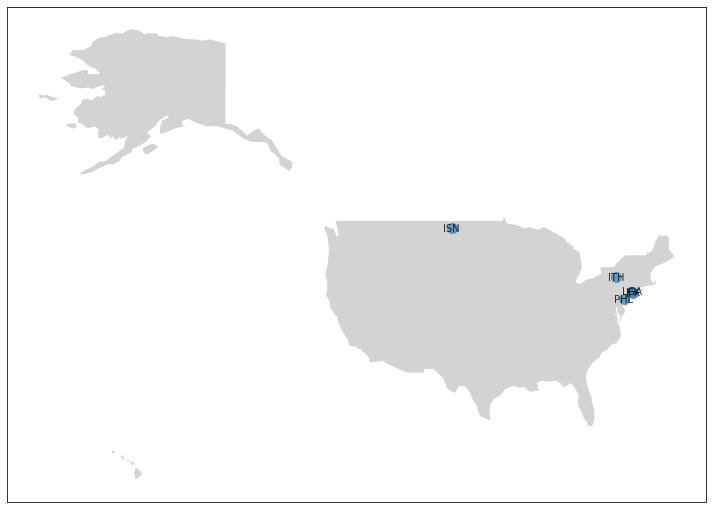

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
countries.query('name == "United States of America"').plot(color="lightgrey", ax=ax)

pos_tax = taxi_out_max.ORIGIN_AIRPORT.values[:5]
nx.draw_networkx_nodes(G, pos, pos_tax, node_size=100, alpha=0.6, ax=ax)
nx.draw_networkx_labels(G, pos, labels={v: v for v in pos_tax}, alpha=0.8, font_size=10)

plt.tight_layout();

In [ ]:
taxi_out_max.iloc[:5]

,ORIGIN_AIRPORT,LATITUDE,LONGITUDE,AIRPORT,CITY,STATE,TAXI_OUT
166,JFK,40.63975,-73.77893,John F. Kennedy International Airport (New Yor...,New York,NY,26.722012
182,LGA,40.77724,-73.87261,LaGuardia Airport (Marine Air Terminal),New York,NY,26.706471
161,ITH,42.49103,-76.45844,Ithaca Tompkins Regional Airport,Ithaca,NY,22.533333
238,PHL,39.87195,-75.24114,Philadelphia International Airport,Philadelphia,PA,21.535515
159,ISN,48.17794,-103.64235,Sloulin Field International Airport,Williston,ND,20.973694


# Задание № 4 - выбор а/п прилета в зависимости от а/п вылета на основе модели предсказания задержки прибытия (RMSE метрика)

Подход следующий - обучение модели на всем трейн-датасете, берутся отдельные признаки - дистанция, время перелета, авиакомпания и проч. плюс добавляются меры централизации графа и маршрутов. Кросс-валидацией подбираются лучшие гипер-параметры и отбирается лучшая модель по метрике RMSE; на тесте рассчитывается итоговая метрика.

Далее по всем возможным маршрутам из указанного а/п вылета берутся агрегированные признаки (где-то медиана, где-то наиболее частые значения) и по ним строятся предсказания. Из итоговой таблицы с предсказаниями достаются три топ а/п.

Логика такая - из дано только а/п вылета, остальное додумываем сами (задержка будет зависеть не только от временного ряда а/п вылета, но и от прочих факторов - авиакомпании, расстояния между а/п и времени перелета, расположения а/п, времени суток вылета, важности а/п и маршрутов с точки зрения всей транспортной сети и проч.). Соответственно, в отсутствии данных вводных полагаем, что пассажир летит "среднестатистическим" рейсом из а/п вылета до а/п прилета, складывающимся из всех возможных регулярных перелетов, из которых он может выбрать свою поездку.

Используемые признаки:
- характеристики времени вылета по расписанию (месяц, день, день недели, метка выходного дня, час, минута)
- координаты а/п вылета и а/п прилета, расстояние между ними
- планируемое время перелета по расписанию
- названия авиакомпаний в кодировке IATA
- время руления самолетов в а/п вылета и прилета
- показатели, характеризующие важность а/п вылета и прилета, а также маршрутов между ними с точки зрения всей транспортной сети - меры централизации графа по соответствующим нодам и ребрам - degree_centrality, closeness_centrality, betweenness_centrality, edge_betweenness_centrality

Использование остальных показателей нерелевантно либо будет приводить к 'data leakage' (к примеру, причины задержек содержат разбиение общей задержки прибытия от 15 минут на минутные составляющие, время в воздухе, общее фактическое время в пути и проч. косвенно указывают на предсказываемый исход и т.д.).

Использование вышеуказанных признаков, в принципе, видится логичным с точки зрения постановки задачи - "среднестатистический" пассажир, находясь в а/п вылета, видит все имеющиеся вылеты по регулярным маршрутам, доступные ему (предполагаем, что у него нет своего бизнес-джета:), так же условно предполагаем, что билеты на каждый из них имеются) - каждому из данных рейсов соответствуют определенные точные характеристики-предпосылки (есть четкое плановое расписание, неизменные координаты а/п, плановое время перелета и проч.), они и закреплены в фичах. Единственные спорные признаки, как видится, - это время руления самолета в а/п вылета и прилета - но здесь так же можно обосновать, что в каком-то роде это тоже исходная предпосылка - по сути, это зависит от места расположения самолета на аэродроме, при этом, скорее всего, данное расположение распределяется по авикомпаниям не в случайном порядке - как правило, они все "кучкуются" на месте их "парковки" (возможно, удобство ее расположения определяется размером оплаты авиакомпанией), соответственно, на момент выбора рейса и авиакомпании это известный факт.

Дополнительно из датасета будут удалены несостоявшиеся и развернутые рейсы - их доля незначительна, и они считаются выбросами, т.к. это чрезвычайные ситуации.


## Подготовка датасета, генерация признаков

In [ ]:
# дата/время

flights['HOUR'] = flights['SCHEDULED_DEPARTURE'].apply(lambda x: x.hour)
flights['MINUTE'] = flights['SCHEDULED_DEPARTURE'].apply(lambda x: x.minute)

flights['DATE'] = pd.to_datetime(flights[['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE']])
flights['WEEKEND'] = np.where((flights['DAY_OF_WEEK'].values == 6) | (flights['DAY_OF_WEEK'].values == 7), 1, 0)

In [ ]:
# дополнение координат а/п прилета

flights = flights.merge(airports[['LATITUDE', 'LONGITUDE']], left_on='DESTINATION_AIRPORT', right_index=True,
                        suffixes=('_ORIG', '_DEST'))

flights.sort_values('DATE', inplace=True)

In [ ]:
# network

btw_edg = nx.edge_betweenness_centrality(G, weight='counts')

for ap in ['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']:
  flights.set_index(ap, inplace=True)
  flights['{}_DEG'.format(ap)] = pd.Series(nx.degree_centrality(G))
  flights['{}_CLS'.format(ap)] = pd.Series(cls_centr)
  flights['{}_BTW'.format(ap)] = pd.Series(btw_centr)

  flights.reset_index(inplace=True)

flights['EDGE_BTW'] = flights[['ORIGIN_AIRPORT',
                               'DESTINATION_AIRPORT']].apply(lambda ap: btw_edg[(ap[0], ap[1])], axis=1)

In [ ]:
# удаление несостоявшихся рейсов и итоговая проверка нулевых значений

flights = flights.query('DIVERTED == 0 and CANCELLED == 0')
flights.shape, flights.isnull().sum()

((5712770, 50), DESTINATION_AIRPORT              0
 ORIGIN_AIRPORT                   0
 YEAR                             0
 MONTH                            0
 DAY                              0
 DAY_OF_WEEK                      0
 AIRLINE                          0
 FLIGHT_NUMBER                    0
 TAIL_NUMBER                      0
 SCHEDULED_DEPARTURE              0
 DEPARTURE_TIME                   0
 DEPARTURE_DELAY                  0
 TAXI_OUT                         0
 WHEELS_OFF                       0
 SCHEDULED_TIME                   0
 ELAPSED_TIME                     0
 AIR_TIME                         0
 DISTANCE                         0
 WHEELS_ON                        0
 TAXI_IN                          0
 SCHEDULED_ARRIVAL                0
 ARRIVAL_TIME                     0
 ARRIVAL_DELAY                    0
 DIVERTED                         0
 CANCELLED                        0
 CANCELLATION_REASON        5712770
 AIR_SYSTEM_DELAY           4649451
 SECURITY_DEL

In [ ]:
flights.to_csv('/gdrive/My Drive/flights_final.csv')

In [ ]:
flights = pd.read_csv('/gdrive/My Drive/flights_final.csv')

## Трейн/тест сплит и построение моделей

In [ ]:
numerical = ['HOUR', 'MINUTE', 'TAXI_OUT',
             'TAXI_IN', 'SCHEDULED_TIME', 'DISTANCE', 'LATITUDE_ORIG',
             'LONGITUDE_ORIG', 'LATITUDE_DEST', 'LONGITUDE_DEST',
             'ORIGIN_AIRPORT_DEG', 'ORIGIN_AIRPORT_CLS', 'ORIGIN_AIRPORT_BTW',
             'DESTINATION_AIRPORT_DEG', 'DESTINATION_AIRPORT_CLS',
             'DESTINATION_AIRPORT_BTW', 'EDGE_BTW']

categorical = ['MONTH', 'DAY', 'DAY_OF_WEEK', 'WEEKEND', 'AIRLINE']

features = numerical + categorical

len(features)

22

In [ ]:
X, y = flights[features], flights[['ARRIVAL_DELAY']]
X.shape, y.shape

((5712770, 22), (5712770, 1))

In [ ]:
X['AIRLINE'].value_counts()[::-1]

VX      61248
HA      76041
F9      90090
NK     115193
AS     171438
US     194223
B6     262042
MQ     278624
UA     507762
EV     554507
OO     575989
AA     712935
DL     870275
WN    1242403
Name: AIRLINE, dtype: int64

Присутствует неравномерное распределение количества авиакомпаний, сплит потребуется стратифицировать, отключение шаффла для сохранения временного ряда в таком случае невозможно. Признаки даты будут перенесены в категориальные.

При этом даже с учетом стратификации на прогонах кросс-валидации из-за дальнейшего дробления в обучающую выборку будет попадать очень малое количество некоторых объектов, из-за чего метрика на кросс-валидации будет занижаться в связи с менее качественным обучением модели при кросс-валидации.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,
                                                    stratify=X['AIRLINE'],
                                                    random_state=42)

In [ ]:
# базовая линейная модель

prep = ColumnTransformer([("num", StandardScaler(), numerical),
                          ("cat", OneHotEncoder(), categorical)])

X_train_prep = prep.fit_transform(X_train)

clf_base = LinearRegression()
cv_res = cross_val_score(clf_base, X_train_prep, y_train.values, scoring="neg_mean_squared_error",
                         cv=3)
np.sqrt(-cv_res).mean()

37.09941405162644

На простейшей линейной модели ошибка RMSE в 37 минут - примерно соответствует среднеквадратическому отклонению предсказываемого значения. При этом интересно, что показатель немного улучшился при переносе признаков даты (месяц, число, день недели) в категориальную группу - модель не выучивает закономерность от величины данных значений, что более логично - к примеру, задержка не будет зависеть от величины сегодняшнего числа или месяца.

Необходимо производить регуляризацию модели - многие признаки находятся в определенной зависимости друг от друга - к примеру, координаты и расстояние, и планируемое время перелета, и проч. (т.е. присутствует мультиколлинеарность признаков), кроме того, некоторые из них могут быть излишними, т.к. одно косвенно выражается через другое (расстояние/координаты). Для снижения весов коэффициентов соответствующих признаков будет использована l2 регуляризация, для исключения влияния некоторых излишних признаков - l1 регуляризация. Для ускорения расчетов и удобства будет использован стохастический градиентный спуск с гиперпараметром ElasticNet, сами коэф. будут подбираться с использованием GridSearchCV. Так же в связи с величиной датасета будет увеличен максимум итераций, но добавлена дополнительная регуляризация ранней остановки.


In [ ]:
sgd_reg = SGDRegressor(penalty='elasticnet', max_iter=10000, early_stopping=True,
                       n_iter_no_change=100, random_state=42)

param = {'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
         'alpha': [0.5, 1, 5, 10]}

sgd_grid = GridSearchCV(sgd_reg, param, scoring="neg_mean_squared_error",
                        cv=3)

sgd_grid.fit(X_train_prep, y_train.values.ravel())

In [ ]:
res = sgd_grid.cv_results_
for mean_score, params in zip(res["mean_test_score"], res["params"]):
    print(np.sqrt(-mean_score), params)

37.76947777363044 {'alpha': 0.5, 'l1_ratio': 0}
37.74579625651465 {'alpha': 0.5, 'l1_ratio': 0.25}
37.72723303106984 {'alpha': 0.5, 'l1_ratio': 0.5}
37.676421122767536 {'alpha': 0.5, 'l1_ratio': 0.75}
37.61762182871693 {'alpha': 0.5, 'l1_ratio': 1}
38.07143187731654 {'alpha': 1, 'l1_ratio': 0}
38.0695159422508 {'alpha': 1, 'l1_ratio': 0.25}
37.9346027646568 {'alpha': 1, 'l1_ratio': 0.5}
37.8730212146912 {'alpha': 1, 'l1_ratio': 0.75}
37.77956835355772 {'alpha': 1, 'l1_ratio': 1}
38.844722587929624 {'alpha': 5, 'l1_ratio': 0}
38.84157246623933 {'alpha': 5, 'l1_ratio': 0.25}
38.824533204440854 {'alpha': 5, 'l1_ratio': 0.5}
38.79603866999103 {'alpha': 5, 'l1_ratio': 0.75}
38.64166560747114 {'alpha': 5, 'l1_ratio': 1}
39.028875646780435 {'alpha': 10, 'l1_ratio': 0}
39.134710654064065 {'alpha': 10, 'l1_ratio': 0.25}
39.149378901306896 {'alpha': 10, 'l1_ratio': 0.5}
39.22484626796344 {'alpha': 10, 'l1_ratio': 0.75}
39.318801695262806 {'alpha': 10, 'l1_ratio': 1}


Лучший результат дала l1 регуляризация (некоторые признаки были исключены в расчете модели), однако лучший коэф. регуляризации оказался в нижней границе. Дальнейший ручной подбор SGD с постепенным снижением гиперпараметра alpha данной регуляризации показал наилучший результат с коэффициентом 0,0001 - метрика составила 37,12, что чуть хуже базовой лин. модели.

In [ ]:
sgd_reg = SGDRegressor(penalty='l1', alpha=0.0001, random_state=42)

cv_res = cross_val_score(sgd_reg, X_train_prep, y_train.values.ravel(),
                         scoring="neg_mean_squared_error", cv=3)
np.sqrt(-cv_res).mean()

37.11568221684674

Важность признаков по итогам селекции l1 регуляризации

In [ ]:
sgd_reg.fit(X_train_prep, y_train.values.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l1', power_t=0.25, random_state=42,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [ ]:
feat = numerical + list(prep.named_transformers_["cat"].get_feature_names())
feat_imp_sgd = [(feat[i], sgd_reg.coef_[i]) for i in abs(sgd_reg.coef_).argsort()[::-1]]
feat_imp_sgd[:20]

[('SCHEDULED_TIME', -38.33539062789098),
 ('DISTANCE', 35.543700281394145),
 ('TAXI_OUT', 9.827703281960565),
 ('x4_NK', 8.344673103887862),
 ('TAXI_IN', 5.499932277591741),
 ('x4_F9', 5.191595849024653),
 ('x4_DL', -5.0628154864454356),
 ('x0_10', -4.9989255663082774),
 ('x4_US', -4.962001936170403),
 ('x0_9', -4.950423206301903),
 ('x0_6', 4.574280341835797),
 ('x1_18', 4.476245723677551),
 ('LONGITUDE_ORIG', 4.461151087108969),
 ('x4_WN', 4.095008958888487),
 ('HOUR', 3.623877778779856),
 ('LONGITUDE_DEST', -3.5762506335527022),
 ('x4_AS', -3.2488809240994376),
 ('x3_0', 3.190208419854366),
 ('x0_2', 3.1357518078226945),
 ('x4_HA', -3.0342663697345627)]

In [ ]:
len([feat for feat in feat_imp_sgd if feat[1] == 0])

7

В 20ку признаков с наивысшими коэффициентами вошли расстояние между а/п и плановое время пути, а также время руления, час вылета, определенные месяцы и даты, и некоторые отдельные авиакомпании. Всего модель исключила из расчетов 7 признаков.

В связи с величиной датасета, а также ограниченного времени работы над проектом использование таких алгоритмов как RandomForestRegressor, SVR затруднено (запущенные аналогичные кросс-валидации данных алгоритмов с дефолтными гипер-параметрами исполнялись более 2х часов и так и не завершились, поэтому далее для сравнения с бенч-марк метриками базовых линейных моделей будет рассчитываться алгоритм CatBoostRegressor с использованием графического процессора.

In [ ]:
cat_reg = CatBoostRegressor(eval_metric='RMSE', task_type='GPU',
                            cat_features=categorical, random_state=42)

cv_res = cross_val_score(cat_reg, X_train, y_train.values.ravel(), scoring="neg_mean_squared_error")

In [ ]:
np.sqrt(-cv_res).mean()

35.58673005197228

Средний показатель метрики на кросс-валидации превзошел базовую модель - 35,6 и 37,1 мин. соответственно.

In [ ]:
cb = CatBoostRegressor(eval_metric='RMSE', task_type='GPU',
                        cat_features=categorical, random_state=42)

param = {'n_estimators': [500, 1000],
         'learning_rate': [0.05, 0.1],
         'depth': [4, 6],
         'l2_leaf_reg': [1, 3]}

cb_grid = cb.grid_search(param, X_train, y_train.values.ravel(), cv=3)
cb_grid.get_params()

In [ ]:
cb_cust = CatBoostRegressor(n_estimators=1000, learning_rate=0.1, depth=6,
                            l2_leaf_reg=3, eval_metric='RMSE', task_type='GPU',
                            cat_features=categorical, random_state=42)

cv_res = cross_val_score(cat_reg, X_train, y_train.values.ravel(), scoring="neg_mean_squared_error")

In [ ]:
np.sqrt(-cv_res).mean()

35.735250221452915

В связи с ограниченностью ресурсов автоматический подбор гиперпараметров не осуществим. Дополнительно произведен повторный расчет с ручным измененением некоторых гиперпараметров, результат не улучшился, поэтому итогово будет использована модель с дефолтными параметрами.

## Обучение лучшей модели и оценка метрики на тестовом датасете

In [ ]:
cb_reg = CatBoostRegressor(eval_metric='RMSE', task_type='GPU',
                            cat_features=categorical, random_state=42)

cb_reg.fit(X_train, y_train.values.ravel())
cb_reg.save_model('/gdrive/My Drive/model.cbm')

In [ ]:
mean_squared_error(y_test, cb_reg.predict(X_test), squared=False)

35.97053702154257

In [ ]:
sorted(list(zip(cb_reg.feature_names_, cb_reg.get_feature_importance())), key=lambda x: x[1], reverse=True)

[('TAXI_OUT', 19.011730328433234),
 ('MONTH', 13.533370901396038),
 ('HOUR', 11.471569031758774),
 ('DAY', 9.242119238116693),
 ('AIRLINE', 8.45394411682897),
 ('TAXI_IN', 8.378979321596738),
 ('LONGITUDE_ORIG', 6.273054494025125),
 ('SCHEDULED_TIME', 4.295429304206057),
 ('LONGITUDE_DEST', 3.6111338099497527),
 ('DISTANCE', 2.6477000736764826),
 ('LATITUDE_ORIG', 2.343918860771348),
 ('DAY_OF_WEEK', 2.2296928035520325),
 ('DESTINATION_AIRPORT_DEG', 1.7419266837495384),
 ('ORIGIN_AIRPORT_DEG', 1.53974221394105),
 ('LATITUDE_DEST', 1.4115094692462127),
 ('ORIGIN_AIRPORT_BTW', 1.0504091111674845),
 ('ORIGIN_AIRPORT_CLS', 0.9426708948483891),
 ('DESTINATION_AIRPORT_BTW', 0.8690105379316438),
 ('DESTINATION_AIRPORT_CLS', 0.4740500977298268),
 ('WEEKEND', 0.2444988211569357),
 ('MINUTE', 0.20696619630947302),
 ('EDGE_BTW', 0.02657368960827567)]

## Подбор топ-3 а/п прилета

In [ ]:
flights.query('ORIGIN_AIRPORT == "JFK"').DESTINATION_AIRPORT.unique()

array(['SJU', 'MIA', 'BQN', 'ATL', 'MCO', 'PBI', 'TPA', 'FLL', 'SFO',
       'LAX', 'PHX', 'RSW', 'MSY', 'LAS', 'BOS', 'BUF', 'RDU', 'SRQ',
       'IAD', 'CHS', 'SAV', 'MSP', 'STT', 'ORD', 'JAX', 'CLT', 'HOU',
       'AUS', 'HNL', 'DTW', 'DFW', 'SEA', 'DCA', 'SAN', 'BTV', 'ROC',
       'SLC', 'SYR', 'PWM', 'LGB', 'CVG', 'CLE', 'CMH', 'ORF', 'IND',
       'BWI', 'OAK', 'BNA', 'EGE', 'BUR', 'SAT', 'SJC', 'PDX', 'SMF',
       'ABQ', 'DEN', 'PSE', 'JAC', 'PSP', 'PIT', 'ACK', 'MVY', 'RNO',
       'HYA'], dtype=object)

In [ ]:
def airports_selector(aip):
    df = flights.query('ORIGIN_AIRPORT == @aip')
    df_agg = df.groupby('DESTINATION_AIRPORT',
                        as_index=False).agg({'HOUR': 'median',
                                       'MINUTE': 'median',
                                       'TAXI_OUT': 'median',
                                       'TAXI_IN': 'median',
                                       'SCHEDULED_TIME': 'median',
                                       'DISTANCE': lambda x: x.value_counts().index[0],
                                       'LATITUDE_ORIG': lambda x: x.value_counts().index[0],
                                       'LONGITUDE_ORIG': lambda x: x.value_counts().index[0],
                                       'LATITUDE_DEST': lambda x: x.value_counts().index[0],
                                       'LONGITUDE_DEST': lambda x: x.value_counts().index[0],
                                       'ORIGIN_AIRPORT_DEG': lambda x: x.value_counts().index[0],
                                       'ORIGIN_AIRPORT_CLS': lambda x: x.value_counts().index[0],
                                       'ORIGIN_AIRPORT_BTW': lambda x: x.value_counts().index[0],
                                       'DESTINATION_AIRPORT_DEG': lambda x: x.value_counts().index[0],
                                       'DESTINATION_AIRPORT_CLS': lambda x: x.value_counts().index[0],
                                       'DESTINATION_AIRPORT_BTW': lambda x: x.value_counts().index[0],
                                       'EDGE_BTW': lambda x: x.value_counts().index[0],
                                       'MONTH': lambda x: x.value_counts().index[0],
                                       'DAY': lambda x: x.value_counts().index[0],
                                       'DAY_OF_WEEK': lambda x: x.value_counts().index[0],
                                       'AIRLINE': lambda x: x.value_counts().index[0]})

    cols = list(df_agg.columns[:-1]) + ['WEEKEND'] + ['AIRLINE']
    df_agg['WEEKEND'] = np.where((df_agg['DAY_OF_WEEK'].values == 6) | (df_agg['DAY_OF_WEEK'].values == 7), 1, 0)
    df_agg = df_agg[cols]
    df_agg['pred_DEL'] = cb_reg.predict(df_agg.drop('DESTINATION_AIRPORT', axis=1))

    return df_agg.sort_values('pred_DEL')[['DESTINATION_AIRPORT', 'pred_DEL']].iloc[:3]

In [ ]:
for a in airports.IATA_CODE.values:
    print(a)
    print(airports_selector(a))
    print('*********************************')

ABE
  DESTINATION_AIRPORT   pred_DEL
1                 DTW  -3.462961
0                 ATL   3.571894
2                 ORD  19.126455
*********************************
ABI
  DESTINATION_AIRPORT  pred_DEL
0                 DFW -4.503441
*********************************
ABQ
   DESTINATION_AIRPORT  pred_DEL
13                 MDW -9.167442
16                 ORD -9.083221
1                  BWI -5.980667
*********************************
ABR
  DESTINATION_AIRPORT  pred_DEL
0                 MSP  5.676619
*********************************
ABY
  DESTINATION_AIRPORT  pred_DEL
0                 ATL -5.120741
*********************************
ACK
  DESTINATION_AIRPORT   pred_DEL
2                 JFK  -0.407516
1                 DCA  31.671647
0                 BOS  62.837425
*********************************
ACT
  DESTINATION_AIRPORT  pred_DEL
0                 DFW    1.0819
*********************************
ACV
  DESTINATION_AIRPORT   pred_DEL
0                 SFO  31.641232
************